### Import Packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os

from fancyimpute import KNN, SimpleFill
from sklearn import model_selection, preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer
import sklearn.metrics as sklm
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, Ridge, RidgeCV,ElasticNetCV,ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
color = sns.color_palette()


from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic

from subprocess import check_output


%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

/Users/hubertjenq/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Import data

In [2]:
# change wd and import data files
os.chdir("/Users/hubertjenq/kaggle/sberbank russian housing")
train_df = pd.read_csv("train.csv",parse_dates=['timestamp'])
test_df = pd.read_csv("test.csv",parse_dates=['timestamp'])
VIFvalues=pd.read_csv("VIFvalues.csv")

#use only low VIF columns from the macro data
macroecon_cols = ["balance_trade", "balance_trade_growth", "eurrub", "average_provision_of_build_contract",
"micex_rgbi_tr", "micex_cbi_tr", "deposits_rate", "mortgage_value", "mortgage_rate",
"income_per_cap", "rent_price_4+room_bus", "museum_visitis_per_100_cap", "apartment_build"]
macro_df = pd.read_csv("macro.csv", parse_dates=['timestamp'], usecols=['timestamp'] + macroecon_cols)

#full macro data
fullmacro_df = pd.read_csv("macro.csv", parse_dates=['timestamp'])

## Data Quality/error fixes

In [3]:
#drop the top 1% and bottom 1% price docs

#price_ulimit = np.percentile(train_df.price_doc.values, 99)
#price_llimit = np.percentile(train_df.price_doc.values, 1)

price_ulimit=1e8

train_df =  train_df.loc[train_df['price_doc'] < price_ulimit] 
#train_df =  train_df.loc[train_df['price_doc'] > price_llimit] 

#add number of nulls
train_df["null_count"] = train_df.isnull().sum(axis=1)
test_df["null_count"] = test_df.isnull().sum(axis=1)

#fix wrong state to the most occured state
train_df.loc[train_df['state'] == 33, 'state'] = train_df['state'].mode().iloc[0]

#fix build year errors
train_df[train_df['build_year']==0]['build_year']=np.nan
train_df[train_df['build_year']==1]['build_year']=np.nan
train_df[train_df['build_year']==3]['build_year']=np.nan
train_df[train_df['build_year']==4965]['build_year']=np.nan
train_df[train_df['build_year']==71]['build_year']=np.nan

In [4]:
train_df['build_year']=train_df['build_year'].replace(215,2015)
train_df['build_year']=train_df['build_year'].replace(20052009,2005)
train_df['build_year']=train_df['build_year'].replace(20,2000)

### resample the investment for more accurate validation

In [5]:

sub_df = train_df[train_df.timestamp < '2015-01-01']
sub_df = sub_df[sub_df.product_type.values == 'Investment']

ind_1m = sub_df[sub_df.price_doc <= 1000000].index
ind_2m = sub_df[sub_df.price_doc == 2000000].index
ind_3m = sub_df[sub_df.price_doc == 3000000].index

train_index = set(train_df.index.copy())

for ind, gap in zip([ind_1m, ind_2m, ind_3m], [10, 3, 2]):
    ind_set = set(ind)
    ind_set_cut = ind.difference(set(ind[::gap]))

    train_index = train_index.difference(ind_set_cut)

train_df = train_df.loc[train_index, :]


### Generate features that depend on the train/test set

### Merge train/test for more cleaning/feature generation

In [6]:

#Make a data frame with all the data in it

#count test/train data
num_train=train_df.shape[0]
num_test=train_df.shape[0]

#save id and price of the train/test 
train_id=train_df['id']
train_logprice=np.log1p(train_df['price_doc'].values)
test_id=test_df['id']

#drop id and price
train_df.drop(['price_doc'],axis=1,inplace=True)


In [7]:
#Combine test/train and the macro data by timestamp
all_df = pd.concat([train_df,test_df])
all_df = pd.merge_ordered(all_df,macro_df,on='timestamp',how='left')

In [8]:
#remove extreme life/full square footage values and set as NA

full_sq_ulimit = 250
life_sq_ulimit = 250
full_sq_llimit = 10
life_sq_llimit = 5

all_df.loc[all_df['full_sq']>full_sq_ulimit, 'full_sq'] = np.nan
all_df.loc[all_df['full_sq']<full_sq_llimit, 'full_sq'] = np.nan
all_df.loc[all_df['life_sq']>life_sq_ulimit, 'life_sq'] = np.nan
all_df.loc[all_df['life_sq']<life_sq_llimit, 'life_sq'] = np.nan

#all_df=all_df.loc[all_df['full_sq']<full_sq_ulimit]
#all_df=all_df.loc[all_df['full_sq']>full_sq_llimit]
#all_df=all_df.loc[all_df['life_sq']<life_sq_ulimit]
#all_df=all_df.loc[all_df['life_sq']>life_sq_llimit]

#make material an object type
all_df['material']=all_df['material'].astype(object)

#living square footage is probably incorrect if it is over 90% of total square footage, so set to NA
all_df['life_full_ratio'] = all_df['life_sq'] / all_df['full_sq']
all_df.loc[all_df['life_full_ratio'] > 0.9, 'life_sq'] = .9*all_df.life_sq

#Set max/floor floor values of 0 to nan
all_df.loc[all_df['floor'] == 0, 'floor'] = np.nan
all_df.loc[all_df['max_floor'] == 0, 'max_floor'] = np.nan
all_df.loc[all_df['max_floor'] == 1, 'max_floor'] = np.nan


#Set the max/floor values to nan if the floor is higher than the "max floor"
all_df.loc[all_df['max_floor'] < all_df['floor'], ['floor', 'max_floor']] = np.nan
#remove buildings built in the future/very old buildings
all_df.loc[all_df['build_year'] > 2017, 'build_year'] = np.nan
all_df.loc[all_df['build_year'] < 1900, 'build_year'] = np.nan


### All data error fixes

In [9]:

#remove num room for extremes
all_df.loc[all_df['num_room'] == 0, 'num_room'] = np.nan
all_df.loc[all_df['num_room'] >= 10, 'num_room'] = np.nan

#set smaller than 3 kitchen_sq's to not footage
all_df.loc[all_df['kitch_sq'] <= 3.0 , 'kitch_sq'] = np.nan

#if the house is a high percentage kitchen, set the kitchen to na
all_df.loc[all_df['full_sq'] - all_df['kitch_sq'] <= 5.0 , 'kitch_sq'] = np.nan

#state typo
all_df.loc[all_df['state'] == 33 , 'state'] = 3


### Make new features

In [10]:
#Convert timestamp to year, month, day of week, and date 
all_df['yearsale']=pd.DatetimeIndex(all_df['timestamp']).year
all_df['monthsale']=pd.DatetimeIndex(all_df['timestamp']).month
all_df['dayofweeksale']=pd.DatetimeIndex(all_df['timestamp']).weekday
all_df['dateofsale']=pd.DatetimeIndex(all_df['timestamp']).day


In [11]:
#add houseage
all_df['houseage']=2017-all_df['build_year']

def add_count(df, group_col):
    grouped_df = df.groupby(group_col)["id"].aggregate("count").reset_index()
    grouped_df.columns = [group_col, "count_"+group_col]
    df = pd.merge(df, grouped_df, on=group_col, how="left")
    return df

#properties sold in the month
all_df['yearmonth']=100*all_df['yearsale']+all_df['monthsale']

all_df['numdays']=365*(all_df['yearsale']-2011)+all_df['monthsale']*30+all_df['dateofsale']
all_df = add_count(all_df, "yearmonth")

In [12]:
#add number of floors from top
all_df['floorsfromtop']=all_df['max_floor']-all_df['floor'].astype(float)
#relative floors
all_df['relativefloor']=all_df['floor']/all_df['max_floor'].astype(float)
#add average room size
all_df['avgroomsize']=all_df['full_sq']/all_df['num_room'].astype(float)
#add kitchen size percentage of house
all_df['kitchenpercentage']=all_df['kitch_sq']/all_df['full_sq'].astype(float)


all_df = pd.merge_ordered(all_df,macro_df,on='timestamp',how='left')

#drop timestamp
all_df.drop(['timestamp','id'],inplace=True,axis=1)

#Drop high VIF
#drop covariates based on VIF:
#VIFvalues.VIF>1000
#highVIF = VIFvalues[0:50].covariate.values
#all_df.drop(highVIF,inplace=True,axis=1)

In [13]:
all_obj_df=all_df.select_dtypes(include=['object']).copy()
all_num_df=all_df.select_dtypes(exclude=['object'])
#XforVIF=all_num_df.copy()[:num_train]

##CHANGE HERE
#all_num_df=ReducedX

#Change catagorical variables to factors

#OHE
oheObjects=pd.get_dummies(all_obj_df)
all_df_values=pd.concat([all_num_df,oheObjects],axis=1)

#BY FACTORIZE
#for c in all_obj_df:
#    all_obj_df[c] = pd.factorize(all_obj_df[c])[0]
    
#convert to numeric values
all_x = all_df_values.values

colnames=all_df_values.columns.values


In [14]:
all_num_df.shape

(36696, 313)

In [15]:
#split all data back into test/training

train_x = all_x[:num_train]
test_x = all_x[num_train:]

plot_x=all_df[:num_train]

#Choose 80% training 20% validation set with these indices
indices = np.random.permutation(train_x.shape[0])
valind = indices[:round(.2*train_x.shape[0])]
trainind = indices[round(.2*train_x.shape[0]):]

#split the training/validation x/
val_x = train_x[valind]
trainmod_x = train_x[trainind]
val_y = train_logprice[valind]
trainmod_y = train_logprice[trainind]


## Missing value imputation

In [16]:
#Impute data for those that need data imputation methods

#median imputation
def medianimputedata(data):
    imputer=preprocessing.Imputer(missing_values='NaN',strategy='median',axis=0)
    imputed_data=pd.DataFrame(imputer.fit_transform(data),columns=colnames)
    return imputed_data

all_x_medianimputed=medianimputedata(all_x)
#split imputed data
train_x_medianimputed = all_x_medianimputed[:num_train]
test_x_medianimputed = all_x_medianimputed[num_train:]
train_x_medianimputed_scaled= scale(train_x_medianimputed)

val_x_medianimputed = train_x_medianimputed.iloc[valind]
trainmod_x_medianimputed = train_x_medianimputed.iloc[trainind]


In [17]:
#KNN imputation
#divide groups for imputation

def KNNimpute(data):
    housechar=range(0,8)
    schools=range(8,26)
    demographics=range(26,53)
    buildingchar=range(53,69)
    disttothings=range(69,134)
    countsperthings=range(134,300)
    macrostats=range(300,395)
    ohe=range(395,587)
    
    index=[housechar,schools,demographics,buildingchar,disttothings,countsperthings,macrostats,ohe]
    datacopy=np.copy(data)
    
    for i in index: 
        if(sum(sum(np.isnan(data))[i])!=0):
            datacopy[:,i]=KNN(k=3).complete(data[:,i])
            print("computing",i)
            
    imputed_data=pd.DataFrame(datacopy,columns=colnames)

    return imputed_data

In [18]:
#test_x_knnimputed = KNNimpute(test_x)
#train_x_knnimputed = KNNimpute(train_x)

In [19]:
#split imputed data
#test_x_knnimputed=pd.DataFrame(test_x_knnimputed,columns=colnames)
#train_x_knnimputed=pd.DataFrame(train_x_knnimputed,columns=colnames)

#test_x_knnimputed.to_csv('test_x_knnimputed.csv', index=False)
#train_x_knnimputed.to_csv('train_x_knnimputed.csv', index=False)

test_x_knnimputed = pd.read_csv("test_x_knnimputed.csv")
train_x_knnimputed = pd.read_csv("train_x_knnimputed.csv")

val_x_knnimputed = train_x_knnimputed.iloc[valind]
trainmod_x_knnimputed = train_x_knnimputed.iloc[trainind]

### Plotting

In [20]:
def jointplot(varname):
    plt.figure(figsize=(6,6))
    values=all_df[:num_train][str(varname)].dropna().values
    notnaindex=np.where(all_df[:num_train][[varname]].notnull())[0]
    sns.jointplot(x=np.transpose(values), y=train_logprice[notnaindex], size=10,kind='kde')
    plt.title('Log price vs. %s' %varname)
    plt.ylabel('Log of Price', fontsize=22)
    plt.xlabel('%s' %varname, fontsize=22)
    plt.savefig('%s vslogprice.png' %varname,dpi=300)
    plt.show()
    return


def xyscatter(xvar,yvar):
    sns.regplot(xvar,yvar,x_bins=50,lowess=True)
    plt.show()
    return



##### Plot Missingness

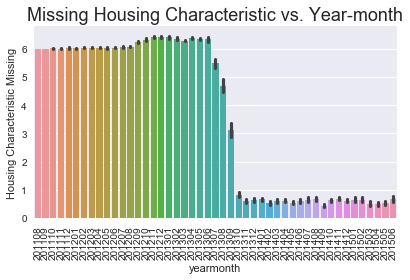

In [21]:
g=plt.figure()
sns.barplot(plot_x['yearmonth'], train_df.iloc[:,:13].isnull().sum(axis=1))
plt.title('Missing Housing Characteristic vs. Year-month',size=18)
plt.ylabel('Housing Characteristic Missing')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.savefig('timevsmissinghousingchar.png',dpi=300)


In [22]:
(train_df.iloc[:,1:13].isnull().sum(axis=0))

timestamp           0
full_sq             0
life_sq          6382
floor             155
max_floor        9007
material         9007
build_year      13035
num_room         9007
kitch_sq         9007
state           12911
product_type        0
sub_area            0
dtype: int64

In [23]:
(all_df.isnull()).sum(axis=0).sum()

465942

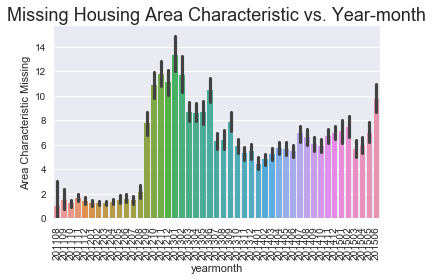

In [24]:
g=plt.figure()
sns.barplot(plot_x['yearmonth'], train_df.iloc[:,13:299].isnull().sum(axis=1))
plt.title('Missing Housing Area Characteristic vs. Year-month',size=18)
plt.ylabel('Area Characteristic Missing')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.savefig('timevsothermissing.png',dpi=300)


In [25]:
#Four plot
ax1=fig.add_subplot(221)
sns.distplot(train_df.price_doc.values, bins=50,kde=False)
ax2=fig.add_subplot(222)
sns.distplot(train_df.full_sq.values, bins=200,kde=False)
plt.xlim(0,500)
ax3=fig.add_subplot(223)
sns.countplot(train_df.floor.values)
ax4=fig.add_subplot(224)
sns.countplot(train_df.num_room.dropna().values)
plt.xlim(0,10)
ax1.set_xlabel('$')
ax1.set_title('House Price')
ax2.set_xlabel('Housing square footage.')
ax2.set_title('Square Meters')
ax3.tick_params(axis = 'x',labelsize=4)
ax3.set_title('Number of Floors')
ax4.set_title('Number of Rooms')
plt.tight_layout()
plt.savefig('test.png',dpi=300)
plt.show()

NameError: name 'fig' is not defined

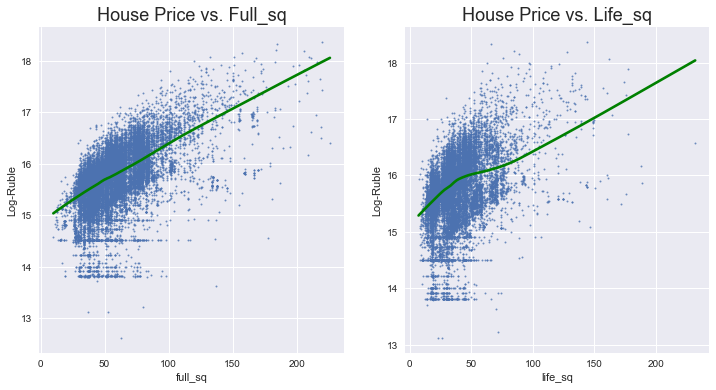

In [26]:
#LOGRUBLE VS FULL SQ
fig=plt.figure(figsize=(12,6))
g=fig.add_subplot(121)
sns.regplot(plot_x['full_sq'],train_logprice,lowess=True,line_kws={"color":"g"},marker='.',scatter_kws={"s":15})
g.set_title('House Price vs. Full_sq',size=18)
g.set_ylabel('Log-Ruble')
g=fig.add_subplot(122)
sns.regplot(plot_x['life_sq'],train_logprice,lowess=True,line_kws={"color":"g"},marker='.',scatter_kws={"s":15})
g.set_title('House Price vs. Life_sq',size=18)
g.set_ylabel('Log-Ruble')
plt.savefig('housepricevsfullsq.png',dpi=300)


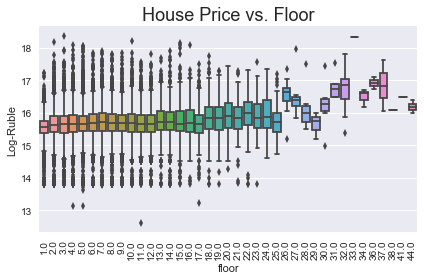

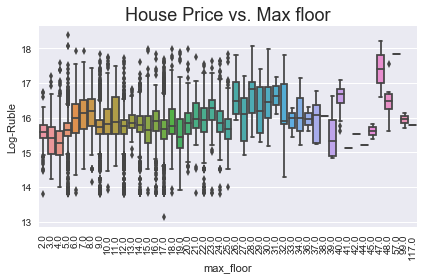

In [28]:
g=plt.figure()
sns.boxplot(plot_x['floor'],train_logprice)
plt.title('House Price vs. Floor',size=18)
plt.ylabel('Log-Ruble')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.savefig('housepricevsfloor.png',dpi=300)


g=plt.figure()
sns.boxplot(plot_x['max_floor'],train_logprice)
plt.title('House Price vs. Max floor',size=18)
plt.ylabel('Log-Ruble')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.savefig('housepricevsmaxfloor.png',dpi=300)


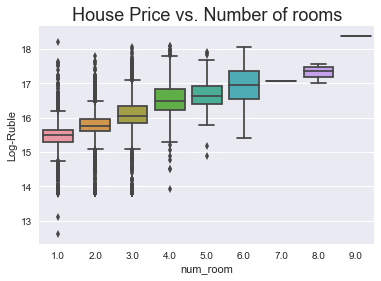

In [29]:
g=sns.boxplot(plot_x['num_room'],train_logprice)
g.set_title('House Price vs. Number of rooms',size=18)
g.set_ylabel('Log-Ruble')
plt.savefig('pricebynumroom.png',dpi=300)

In [30]:
plt.figure(figsize=(12,8))
FloorPricedf=train_df.groupby('num_room').agg({'price_doc':'median'}).reset_index()
sns.pointplot(FloorPricedf['floor'],FloorPricedf['price_doc'],color=color[0])
plt.xticks(rotation='vertical')
plt.ylabel('Median Price')
plt.title('Median Price by Floor', fontsize=20)
plt.savefig('pricebyfloor.png',dpi=300)


/Users/hubertjenq/anaconda3/lib/python3.6/site-packages/pandas/core/groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


KeyError: 'price_doc'

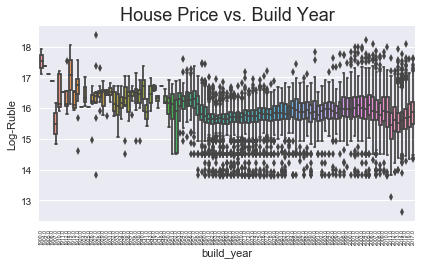

In [31]:
g=plt.figure()
sns.boxplot(plot_x['build_year'],train_logprice)
plt.title('House Price vs. Build Year',size=18)
plt.ylabel('Log-Ruble')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.tick_params(axis='x', which='major', labelsize=5.25)
plt.savefig('pricebybuildyear.png',dpi=300)


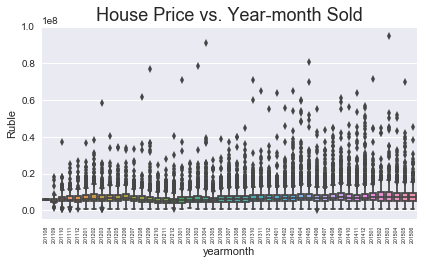

In [32]:
g=plt.figure()
sns.boxplot(plot_x['yearmonth'],np.exp(train_logprice)-1)
plt.title('House Price vs. Year-month Sold',size=18)
plt.ylabel('Ruble')
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.tick_params(axis='x', which='major', labelsize=5.25)
plt.savefig('pricebyyearmonth.png',dpi=300)


In [33]:
#for col in plot_x.columns:
#    if plot_x[col].dtype=='float64' or plot_x[col].dtype=='int64':
#        xyscatter(plot_x[col],train_logprice)

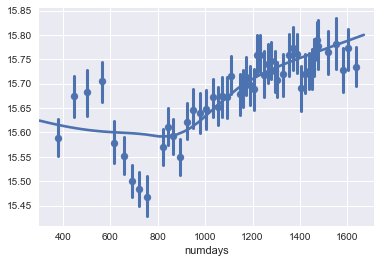

In [34]:
xyscatter(plot_x['numdays'],train_logprice)

In [35]:
#PCA
pca = PCA(n_components=50)

pca.fit(train_x_imputed)
PCAtransX=pca.fit_transform(train_x_imputed)


var= pca.explained_variance_ratio_

NameError: name 'train_x_imputed' is not defined

In [ ]:
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(var1)

## Linear Regression Model (LASSO)

In [ ]:
#Choose variables for the linear model
lassovarb=['full_sq','num_room','ttk_km','sadovoe_km','nuclear_reactor_km','kitchenpercentage','numdays','gdp_annual_growth','cpi']
regularized_x = trainmod_x_knnimputed

In [ ]:
#KNN imputed values
LASSOknnmodel =LassoCV(normalize=True,max_iter=1e5,cv=5)
LASSOknnmodel.fit(trainmod_x_knnimputed,trainmod_y)
LASSOknnvalpred=LASSOknnmodel.predict(val_x_knnimputed)
LASSOknntrainpred=LASSOknnmodel.predict(trainmod_x_knnimputed)
LASSOknnvalerror=np.sqrt(sklm.mean_squared_error(LASSOknnvalpred,val_y))
LASSOknntrainerror=np.sqrt(sklm.mean_squared_error(LASSOknntrainpred,trainmod_y))

print('valerror=',LASSOknnvalerror,'trainerror=',LASSOknntrainerror)

In [ ]:
#Median imputed values
LASSOmedmodel =LassoCV(normalize=True,max_iter=1e5,cv=5)
LASSOmedmodel.fit(trainmod_x_medianimputed,trainmod_y)
LASSOmedvalpred=LASSOmedmodel.predict(val_x_medianimputed)
LASSOmedtrainpred=LASSOmedmodel.predict(trainmod_x_medianimputed)
LASSOmedvalerror=np.sqrt(sklm.mean_squared_error(LASSOmedvalpred,val_y))
LASSOmedtrainerror=np.sqrt(sklm.mean_squared_error(LASSOmedtrainpred,trainmod_y))

print('valerror=',LASSOmedvalerror,'trainerror=',LASSOmedtrainerror)

In [ ]:
LASSOknnmodel.alpha_

## Ridge Regression Model

In [ ]:
Ridgeknnmodel=RidgeCV(normalize=True,alphas=np.linspace(.000001,.1,100))
Ridgeknnmodel.fit(trainmod_x_knnimputed,trainmod_y)
Ridgeknnvalpred=Ridgeknnmodel.predict(val_x_knnimputed)
Ridgeknntrainpred=Ridgeknnmodel.predict(trainmod_x_knnimputed)
Ridgeknntestpred=Ridgeknnmodel.predict(test_x_knnimputed)
Ridgeknnvalerror=np.sqrt(sklm.mean_squared_error(Ridgeknnvalpred,val_y))
Ridgeknntrainerror=np.sqrt(sklm.mean_squared_error(Ridgeknntrainpred,trainmod_y))
print('valerror=',Ridgeknnvalerror,'trainerror=',Ridgeknntrainerror,Ridgeknnmodel.alpha_)

Ridgemedmodel=RidgeCV(normalize=True,alphas=np.linspace(.000001,.1,100))
Ridgemedmodel.fit(trainmod_x_medianimputed,trainmod_y)
Ridgemedvalpred=Ridgemedmodel.predict(val_x_medianimputed)
Ridgemedtrainpred=Ridgemedmodel.predict(trainmod_x_medianimputed)
Ridgemedtestpred=Ridgemedmodel.predict(test_x_medianimputed)
Ridgemedtrainerror=np.sqrt(sklm.mean_squared_error(Ridgemedtrainpred,trainmod_y))
Ridgemedvalerror=np.sqrt(sklm.mean_squared_error(Ridgemedvalpred,val_y))
print('valerror=',Ridgemedvalerror,'trainerror=',Ridgemedtrainerror,Ridgemedmodel.alpha_)


In [ ]:
pd.DataFrame(np.stack((np.absolute(Ridgemedmodel.coef_),colnames),axis=1)).sort_values(0,ascending=False)

## Elastic Net Model

In [ ]:
ElasticNetmodel=ElasticNetCV(normalize=True,max_iter=1e5)
ElasticNetmodel.fit(trainmod_x_knnimputed,trainmod_y)
ElasticNetpred=ElasticNetmodel.predict(val_x_knnimputed)
ElasticNetvalerror=np.sqrt(sklm.mean_squared_error(ElasticNetpred,val_y))
ElasticNetvalerror

In [ ]:
ElasticNetmedmodel=ElasticNetCV(normalize=True,max_iter=1e5)
ElasticNetmedmodel.fit(trainmod_x_medianimputed,trainmod_y)
ElasticNetmedpred=ElasticNetmedmodel.predict(val_x_medianimputed)
ElasticNetmedvalerror=np.sqrt(sklm.mean_squared_error(ElasticNetmedpred,val_y))
ElasticNetmedvalerror

In [ ]:
Linearmodel=LinearRegression()
Linearmodel.fit(trainmod_x_knnimputed,trainmod_y)
LMvalpred=Linearmodel.predict(val_x_knnimputed)
LMtrainpred=Linearmodel.predict(trainmod_x_knnimputed)
LMvalerror=np.sqrt(sklm.mean_squared_error(LMvalpred,val_y))
LMtrainerror=np.sqrt(sklm.mean_squared_error(LMtrainpred,trainmod_y))
print('valerror',LMvalerror,'trianerror ',LMtrainerror)

In [ ]:
Linearmedmodel=LinearRegression()
Linearmedmodel.fit(trainmod_x_medianimputed,trainmod_y)
LMmedvalpred=Linearmedmodel.predict(val_x_medianimputed)
LMmedtrainpred=Linearmedmodel.predict(trainmod_x_medianimputed)

LMmedvalerror=np.sqrt(sklm.mean_squared_error(LMmedvalpred,val_y))
LMmedtrainerror=np.sqrt(sklm.mean_squared_error(LMmedtrainpred,trainmod_y))
print('valerror',LMmedvalerror,'trianerror ',LMmedtrainerror)

## Random Forest Model

In [ ]:
#find how many trees needed to stabilize validation error
rfnumtreeerror=[]
rfnumtreetrainerror=[]
    
RFmodel = RandomForestRegressor(max_features=.33,min_samples_leaf=5,max_depth=8,n_jobs=7)

for i in range(1,200,5):
    RFmodel.set_params(n_estimators=i)
    RFmodel.fit(trainmod_x_knnimputed, trainmod_y)
    error=np.sqrt(sklm.mean_squared_error(RFmodel.predict(val_x_knnimputed),val_y))
    trainerror=np.sqrt(sklm.mean_squared_error(RFmodel.predict(trainmod_x_knnimputed),trainmod_y))

    print(i)
    rfnumtreeerror.append(error)
    rfnumtreetrainerror.append(trainerror)


In [ ]:
plt.plot(rfnumtreeerror)
plt.xlabel("Number of Trees")
plt.ylabel("Validation Error")
plt.title("Number of Trees in RF vs. Validation Error",size=18)
plt.savefig("numtreevsval",dpi=300)

In [ ]:
RFmodel = RandomForestRegressor(n_estimators=60,oob_score=True,max_features=.33,min_samples_leaf=5,max_depth=8,n_jobs=7)
RFmodel.fit(trainmod_x_knnimputed, trainmod_y)
RFvalpred=RFmodel.predict(val_x_knnimputed)
RFtrainpred=RFmodel.predict(trainmod_x_knnimputed)
RFtestpred=RFmodel.predict(test_x_knnimputed)

RFvalerror=np.sqrt(sklm.mean_squared_error(RFvalpred,val_y))
RFtrainerror=np.sqrt(sklm.mean_squared_error(RFtrainpred,trainmod_y))
print('val errror ', RFvalerror, 'train error ', RFtrainerror)

In [ ]:
RFmedmodel = RandomForestRegressor(n_estimators=50,oob_score=True,max_features=.33,min_samples_leaf=5,max_depth=8,n_jobs=7)
RFmedmodel.fit(trainmod_x_medianimputed, trainmod_y)
RFmedvalpred=RFmedmodel.predict(val_x_medianimputed)
RFmedtrainpred=RFmedmodel.predict(trainmod_x_medianimputed)

RFmedvalerror=np.sqrt(sklm.mean_squared_error(RFmedvalpred,val_y))
RFmedtrainerror=np.sqrt(sklm.mean_squared_error(RFmedtrainpred,trainmod_y))
print('val errror ', RFmedvalerror, 'train error ', RFmedtrainerror)



In [ ]:
RFvarimp=pd.DataFrame(np.stack((test_x_knnimputed.columns,RFmedmodel.feature_importances_),axis=1)).sort_values(1,ascending=False)

fig=plt.figure()
numfeatures=25
sns.barplot(RFvarimp.iloc[:,1][0:numfeatures],RFvarimp.iloc[:,0][0:numfeatures],color=color[0])
plt.xlabel('Feature Importance')
plt.ylabel('')
plt.title('Random Forest Feature Importance',size=18)
plt.tight_layout()
plt.savefig('RFfeatimp.png',dpi=300)
plt.show()

In [ ]:
y_log_pred_rf = RFmodel.predict(test_x_imputed)
y_pred_rf = np.exp(y_log_pred_rf) - 1

RFsub = pd.DataFrame({'id': test_id, 'price_doc': y_pred_rf})
RFsub.to_csv('RFsub.csv', index=False)

## XGBoost Model

In [ ]:
#transformer = ReduceVIF()
# Only use 10 columns for speed in this example
#ReducedX = transformer.fit_transform(XforVIF[XforVIF.columns[:]], val_y)

#ReducedX.head()


#ReducedX.to_csv('VIFx.csv', index=False)

In [36]:
xgbfulltrain=xgb.DMatrix(train_x,train_logprice,feature_names=colnames)
xgbtrain=xgb.DMatrix(trainmod_x,trainmod_y,feature_names=colnames)
xgbval=xgb.DMatrix(val_x,val_y,feature_names=colnames)
xgbtest=xgb.DMatrix(test_x,feature_names=colnames)

In [37]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

result={}

partial_model = xgb.train(xgb_params, xgbtrain, num_boost_round=1000 ,evals_result=result ,evals=[(xgbval, 'eval')],early_stopping_rounds=20, verbose_eval=20)
XGBvalpred = partial_model.predict(xgbval)
num_boost_round = partial_model.best_iteration

[0]	eval-rmse:14.4288
Will train until eval-rmse hasn't improved in 20 rounds.
[20]	eval-rmse:5.18682
[40]	eval-rmse:1.88845
[60]	eval-rmse:0.743709
[80]	eval-rmse:0.400973
[100]	eval-rmse:0.328857
[120]	eval-rmse:0.316843
[140]	eval-rmse:0.314442
[160]	eval-rmse:0.313074
[180]	eval-rmse:0.312412
[200]	eval-rmse:0.311935
[220]	eval-rmse:0.311581
[240]	eval-rmse:0.311378
[260]	eval-rmse:0.311206
[280]	eval-rmse:0.311011
[300]	eval-rmse:0.310965
Stopping. Best iteration:
[295]	eval-rmse:0.31088



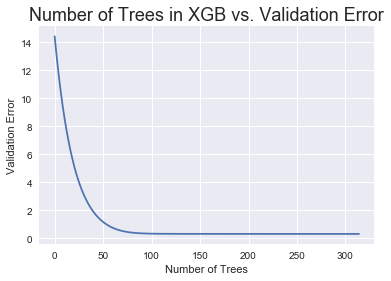

In [38]:
plt.plot(result['eval']['rmse'])
plt.xlabel("Number of Trees")
plt.ylabel("Validation Error")
plt.title("Number of Trees in XGB vs. Validation Error",size=18)
plt.savefig("numtreeXGB",dpi=300)

In [39]:
partial_model.attributes()

{'best_iteration': '295',
 'best_msg': '[295]\teval-rmse:0.31088',
 'best_score': '0.31088'}

In [40]:
model = xgb.train(dict(xgb_params, silent=0), xgbfulltrain, num_boost_round=num_boost_round)
xgbvalpred=model.predict(xgbval)
xgbtestpred=model.predict(xgbtest)
xgbtrainpred=model.predict(xgbtrain)

In [41]:
#Convert the data to xgb matrices

#Remove macro data
train_x_nomacro=np.delete(train_x,range(300,395),1)
trainmod_x_nomacro = np.delete(trainmod_x,range(300,395),1)
val_x_nomacro = np.delete(val_x,range(300,395),1)
test_x_nomacro = np.delete(test_x ,range(300,395),1)
colnames_nomacro = np.delete(colnames,range(300,395))

xgbfulltrain=xgb.DMatrix(train_x_nomacro,train_logprice,feature_names=colnames_nomacro)
xgbtrain=xgb.DMatrix(trainmod_x_nomacro,trainmod_y,feature_names=colnames_nomacro)
#xgbtrain=xgb.DMatrix(PCAtransX[trainind],trainmod_y,feature_names=colnames[:50])
xgbval=xgb.DMatrix(val_x_nomacro,val_y,feature_names=colnames_nomacro)
xgbtest=xgb.DMatrix(test_x_nomacro,feature_names=colnames_nomacro)

#### Find optimal number of boosting Rounds

In [42]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

partial_model = xgb.train(xgb_params, xgbtrain, num_boost_round=1000, evals=[(xgbval, 'eval')],early_stopping_rounds=20, verbose_eval=20)
XGBvalpred = partial_model.predict(xgbval)
num_boost_round = partial_model.best_iteration

[0]	eval-rmse:14.4289
Will train until eval-rmse hasn't improved in 20 rounds.
[20]	eval-rmse:5.18681
[40]	eval-rmse:1.88803
[60]	eval-rmse:0.743493
[80]	eval-rmse:0.401103
[100]	eval-rmse:0.329479
[120]	eval-rmse:0.317296
[140]	eval-rmse:0.314392
[160]	eval-rmse:0.313228
[180]	eval-rmse:0.312624
[200]	eval-rmse:0.312378
[220]	eval-rmse:0.312152
[240]	eval-rmse:0.311743
[260]	eval-rmse:0.311721
[280]	eval-rmse:0.31154
[300]	eval-rmse:0.311384
Stopping. Best iteration:
[299]	eval-rmse:0.311383



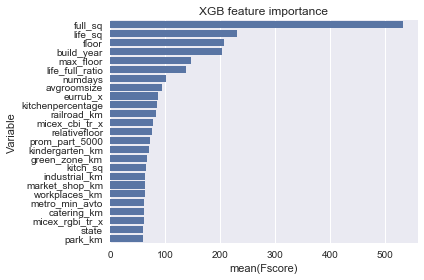

In [43]:
importance = partial_model.get_fscore()
VariableImpDf=pd.DataFrame(list(importance.items()),columns=['Variable','Fscore'])
SortedVIDf=VariableImpDf.sort_values('Fscore',ascending=False)
fig=plt.figure()
numfeatures=25
sns.barplot(SortedVIDf.Fscore[0:numfeatures],SortedVIDf.Variable[0:numfeatures],color=color[0])
plt.title("XGB feature importance")
plt.tight_layout()
plt.savefig('xgbfeatimp.png',dpi=300)


In [44]:
top200= SortedVIDf.Variable[0:200].values

def reducefeatimp(data):
    datadf = pd.DataFrame(data,columns=colnames_nomacro)
    return datadf[top200]

train_x_reduced=reducefeatimp(train_x_nomacro)
trainmod_x_reduced=reducefeatimp(trainmod_x_nomacro)
val_x_reduced=reducefeatimp(val_x_nomacro)
test_x_reduced=reducefeatimp(test_x_nomacro)

xgbfulltrain_reduced=xgb.DMatrix(train_x_reduced.values,train_logprice,feature_names=top200)
xgbtrain_reduced=xgb.DMatrix(trainmod_x_reduced.values , trainmod_y,feature_names=top200)
xgbval_reduced=xgb.DMatrix(val_x_reduced.values , val_y , feature_names=top200)
xgbtest_reduced=xgb.DMatrix(test_x_reduced.values , feature_names=top200)

In [45]:
all_df.columns

Index(['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year',
       'num_room', 'kitch_sq', 'state', 'product_type',
       ...
       'average_provision_of_build_contract_y', 'micex_rgbi_tr_y',
       'micex_cbi_tr_y', 'deposits_rate_y', 'mortgage_value_y',
       'mortgage_rate_y', 'income_per_cap_y', 'rent_price_4+room_bus_y',
       'museum_visitis_per_100_cap_y', 'apartment_build_y'],
      dtype='object', length=329)

[0]	eval-rmse:14.4287
Will train until eval-rmse hasn't improved in 20 rounds.
[20]	eval-rmse:5.18692
[40]	eval-rmse:1.88891
[60]	eval-rmse:0.744374
[80]	eval-rmse:0.401852
[100]	eval-rmse:0.32998
[120]	eval-rmse:0.317775
[140]	eval-rmse:0.314798
[160]	eval-rmse:0.313679
[180]	eval-rmse:0.313019
[200]	eval-rmse:0.312666
[220]	eval-rmse:0.312577
[240]	eval-rmse:0.31232
[260]	eval-rmse:0.312423
Stopping. Best iteration:
[247]	eval-rmse:0.312278



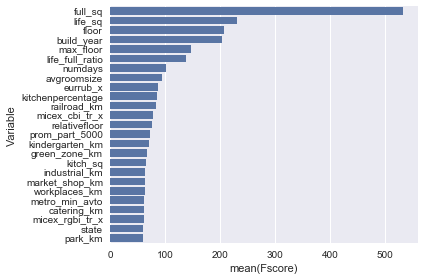

In [46]:
partial_model = xgb.train(xgb_params, xgbtrain_reduced, num_boost_round=1000, evals=[(xgbval_reduced, 'eval')],early_stopping_rounds=20, verbose_eval=20)
num_boost_round = partial_model.best_iteration

VariableImpDf=pd.DataFrame(list(importance.items()),columns=['Variable','Fscore'])
SortedVIDf=VariableImpDf.sort_values('Fscore',ascending=False)
fig=plt.figure()
numfeatures=25
sns.barplot(SortedVIDf.Fscore[0:numfeatures],SortedVIDf.Variable[0:numfeatures],color=color[0])
plt.tight_layout()


In [47]:
model = xgb.train(dict(xgb_params, silent=0), xgbfulltrain_reduced, num_boost_round=num_boost_round)

In [48]:
ylog_pred = model.predict(xgbtest_reduced)
y_pred = np.exp(ylog_pred) - 1

df_sub = pd.DataFrame({'id': test_id, 'price_doc': y_pred})

df_sub.to_csv('sub.csv', index=False)


### Hyperparameter optimization

In [50]:
    #Define parameter space for xgb and random forest
    XGBspace = {
             'n_estimators' : hp.quniform('n_estimators', 200, 400,1),
             'max_depth': hp.choice('max_depth',[3,5,7,9,12,15,17,25]),
             'eta' : hp.choice('eta', [0.01,.015,.025,.05,.1]),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 7,1),
             'subsample' : hp.quniform('subsample', 0.6, 1,.1),
             'gamma' : hp.choice('gamma', [0.05,.1,.3,.5,.7,.9, 1]),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.1),
             'objective': 'reg:linear',
             'eval_metric': 'rmse',
             'silent' : 0,
             'lambda' : hp.choice('lambda',[0.01,.1,1,.05]),
             'alpha' : hp.choice('alpha',[0,.1,.5,1,.05])
             }


    RFspace = {'n_estimators': 60,
               'oob_score':  True,
               'max_features': hp.uniform('max_features',.2,.45),
               'min_samples_leaf': hp.choice('min_samples_leaf',[1,2,5,10]),
               'max_depth': hp.choice('max_depth',[5,8,15,25,30]),
               'n_jobs': 8
              }

In [51]:
def XGBscore(params):
    boost_rounds=int(params['n_estimators'])
    model = xgb.train(params, xgbtrain, num_boost_round=boost_rounds)
    del params['n_estimators']
    
    predictions = model.predict(xgbval)
    yval=xgbval.get_label()
    score = np.sqrt(sklm.mean_squared_error(yval, predictions))
    print("\tObjective {0}\n\n".format(score))
    
    return {'loss': score, 'status': STATUS_OK}

def RFscore(params):
    RFmodel = RandomForestRegressor(**params)
    RFmodel.fit(trainmod_x_medianimputed, trainmod_y)
    score = np.sqrt(sklm.mean_squared_error(RFmodel.predict(val_x_medianimputed),val_y))
    print("\tObjective {0}\n\n".format(score))

    return {'loss': score, 'status': STATUS_OK}

In [53]:
rftrials = Trials()
rfbest = fmin(fn=RFscore, space=RFspace, algo=tpe.suggest, trials=rftrials, max_evals=10)

	Objective 0.3403657462373657


	Objective 0.3172940214485765


	Objective 0.3160481882702428


	Objective 0.3406514672167043


	Objective 0.3128000095582376


	Objective 0.3437273270760524


	Objective 0.31267972428549384


	Objective 0.3450966967452232


	Objective 0.32192195172399096


	Objective 0.312045790037823




In [54]:
xgbtrials = Trials()
xgbbest = fmin(fn=XGBscore, space=XGBspace, algo=tpe.suggest, trials=xgbtrials, max_evals=10)

	Objective 0.49823394417762756


	Objective 0.31265580654144287


	Objective 0.3119831681251526


	Objective 0.45602160692214966


	Objective 0.3171469569206238


	Objective 0.36090341210365295


	Objective 0.5859184861183167


	Objective 1.0649808645248413


	Objective 0.316430926322937


	Objective 0.3101452887058258




In [55]:
rfparams ={'max_features':0.3418,'min_samples_leaf':5,'max_depth':30}

In [56]:
RFmodel = RandomForestRegressor(**rfparams)
RFmodel.fit(trainmod_x_medianimputed, trainmod_y)
    
RFvalpred=RFmodel.predict(val_x_medianimputed)
RFtrainpred=RFmodel.predict(trainmod_x_medianimputed)
RFtestpred=RFmodel.predict(test_x_medianimputed)

RFvalerror=np.sqrt(sklm.mean_squared_error(RFvalpred,val_y))
RFtrainerror=np.sqrt(sklm.mean_squared_error(RFtrainpred,trainmod_y))
print('val errror ', RFvalerror, 'train error ', RFtrainerror)

val errror  0.320279980351 train error  0.226227701895


In [57]:
best={'alpha': 0,
   'colsample_bytree': 0.5,
   'eta': 0.05,
   'gamma': 0.7,
   'lambda': 0.01,
    'max_depth':5,
   'min_child_weight': 7.0,
   'n_estimators': 261,
   'subsample': 1}

In [58]:
model = xgb.train(best, xgbtrain, num_boost_round=int(best['n_estimators']))
yval=xgbval.get_label()
xgbvalpred=model.predict(xgbval)
xgbtrainpred=model.predict(xgbtrain)
xgbtestpred=model.predict(xgbtest)
xgbvalerror=np.sqrt(sklm.mean_squared_error(yval, model.predict(xgbval)))
xgbtrainerror=np.sqrt(sklm.mean_squared_error(trainmod_y, model.predict(xgbtrain)))
print('val errror ', xgbvalerror, 'train error ', xgbtrainerror)


val errror  0.309557 train error  0.273570526861


In [59]:
def bestTrial(trialsfromopt):
    values=[]
    for x in range(0,len(trialsfromopt)):
        values.append(trialsfromopt.results[x]['loss'])
    vallist=np.asarray(values)
    top5 = [trialsfromopt.trials[i] for i in np.argsort(vallist)[:3]]
    return top5

In [60]:
ylog_pred = model.predict(xgbtest)
y_pred = np.exp(ylog_pred) - 1

df_sub = pd.DataFrame({'id': test_id, 'price_doc': y_pred})

df_sub.to_csv('sub.csv', index=False)


## model Stack

In [61]:
valstack=np.stack((RFvalpred,xgbvalpred,Ridgeknnvalpred),axis=1)
trainstack=np.stack((RFtrainpred,xgbtrainpred,Ridgeknntrainpred),axis=1)
teststack=np.stack((RFtestpred,xgbtestpred,Ridgeknntestpred),axis=1)

NameError: name 'Ridgeknnvalpred' is not defined

In [ ]:
stackmodel=LinearRegression()
stackmodel.fit(trainstack,trainmod_y)
stackvalpred=stackmodel.predict(valstack)
stacktrainpred=stackmodel.predict(trainstack)
LMvalerror=np.sqrt(sklm.mean_squared_error(stackvalpred,val_y))
LMtrainerror=np.sqrt(sklm.mean_squared_error(stacktrainpred,trainmod_y))

print(LMvalerror,LMtrainerror)

In [ ]:
stackmodel.coef_

In [ ]:

stacktestpred = np.exp(logstacktestpred) - 1

df_sub = pd.DataFrame({'id': test_id, 'price_doc': stacktestpred})

df_sub.to_csv('sub.csv', index=False)
